# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [31]:
# import libraries
import pandas as pd
import numpy as np

import pickle

from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# load data from database
engine = create_engine('sqlite:///Messages_and_categories.db')

df = pd.read_sql('SELECT * FROM Messages_and_categories', engine)
X = df['message'].values
y = df.drop(['id','message','original','genre'], axis=1)
feature_names = list(y.columns.values)

In [42]:
df.shape

(26216, 40)

In [3]:
# This is a multi-class problem (several outcome variables). What are the outcomes?
feature_names

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [38]:
# Are the categories mutually exclusive? No, this is a multi-label classification.
nbr_cat = y.sum(axis=1).value_counts().sort_index()
nbr_cat

0     6122
1     5121
2      631
3     3609
4     2276
5     2956
6     1903
7     1347
8      880
9      577
10     344
11     183
12     107
13      57
14      38
15      20
16       8
17      12
18       7
19       5
20       4
21       4
22       2
24       1
27       2
dtype: int64

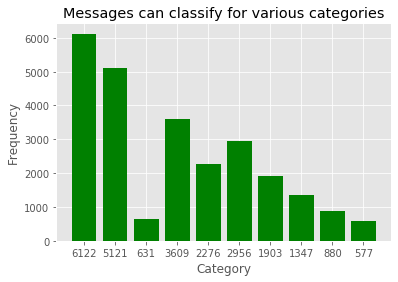

In [59]:
nbr_cat = list(nbr_cat[:10])
x_pos = list(range(0, 10))

plt.bar(x_pos, nbr_cat, color='green')
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title("Many messages classify for various categories")

plt.xticks(x_pos, nbr_cat)

plt.show()

In [ ]:
# Which categories are likely?
y.sum(axis=0).sort_values(ascending=False)

In [26]:
occur = list(y.sum(axis=0).sort_values(ascending=False))
occur_top5 = occur[:5]
occur_top5


[20282, 10860, 7297, 5075, 4474]

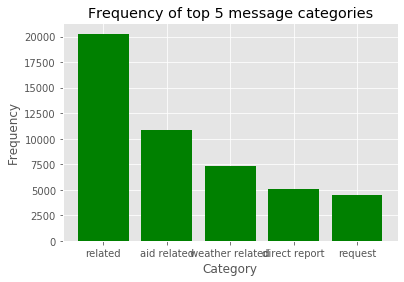

In [29]:
occur_top5_names = ["related", "aid related", "weather related", "direct report", "request"]
x_pos = [i for i, _ in enumerate(occur_top5)]

plt.bar(x_pos, occur_top5, color='green')
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title("Frequency of top 5 message categories")

plt.xticks(x_pos, occur_top5_names)

plt.show()

### 2. Write a tokenization function to process your text data

In [6]:
def tokenize(text):
    tokens = word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [7]:
test = tokenize(X[0])
test

KeyboardInterrupt: 

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def model_pipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])
    return pipeline

In [ ]:
model = model_pipeline()
model.fit(X_train, y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(data=y_pred, columns=feature_names)
y_test = pd.DataFrame(data=y_test, columns=feature_names)

In [ ]:
# View accuracy score
def show_accuracy():
    for column in y.columns:
        print('\n---- {} ----\n{}\n'.format(column, accuracy_score(y_test[column], y_pred[column])))

In [ ]:
# Classification report
def show_class_report():
    for column in y.columns:
        print('\n---- {} ----\n{}\n'.format(column, classification_report(y_test[column], y_pred[column])))

In [ ]:
# View confusion matrix for test data and predictions
def show_confusion_matrix():
    for column in y.columns:
        print('\n---- {} ----\n{}\n'.format(column, confusion_matrix(y_test[column], y_pred[column])))

In [ ]:
show_accuracy()

In [ ]:
show_class_report()

In [ ]:
show_confusion_matrix()

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
def model_pipeline_search():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])
    
    parameters = {
        'clf__estimator__criterion': ['gini', 'entropy'],
        'clf__estimator__max_depth': [2, 5, None],
        'clf__estimator__n_estimators': [10, 20, 50]
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)
    return cv

In [ ]:
model_search = model_pipeline_search()
model_search.fit(X_train, y_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred = model_search.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(data=y_pred, columns=feature_names)
y_test = pd.DataFrame(data=y_test, columns=feature_names)

In [ ]:
show_accuracy()

In [ ]:
show_class_report()

In [ ]:
show_confusion_matrix()

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
def model_pipeline_search_knn():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier()))
        ])
    
    parameters = {
        'n_neighbors': [3,5,11,19],
        'weights': ["uniform", "distance"],
        'metric': ["euclidean", "manhattan"]
    }

    cv = GridSearchCV(pipeline, param_grid=parameters, verbose = 1, cv=3)
    return cv

In [ ]:
model_knn = model_pipeline_search_knn()
model_knn.fit(X_train, y_train)

In [ ]:
y_pred = model_knn.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(data=y_pred, columns=feature_names)
y_test = pd.DataFrame(data=y_test, columns=feature_names)

In [ ]:
show_accuracy()

In [ ]:
show_class_report()

In [ ]:
show_confusion_matrix()

### 9. Export your model as a pickle file

In [ ]:
#pickle.dump(model,open(model_filepath,'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.